In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing the Libraries

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load Data, Data Cleaning & Preprocessing

In [44]:
# Load data
df = pd.read_csv('/content/drive/MyDrive/Teknologi-Informasi/Praktikum-BigData/nvda.us.txt')

In [45]:
# 1. DATA CLEANING
print("--- 1. Data Cleaning ---")

# Ubah kolom Date menjadi tipe datetime dan urutkan
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df = df.set_index('Date')
print(f"DataFrame awal: {df.shape[0]} baris.")

# Siapkan dataframe khusus untuk membuat feature
data = df[['Close']].copy()

--- 1. Data Cleaning ---
DataFrame awal: 4733 baris.


In [85]:
# --- 2. FEATURE ENGINEERING (DIPERBAIKI DENGAN IDE BARU) ---
print("\n--- 2. Data Preprocessing (Feature Engineering) ---")

# FITUR BARU
# Lagged Close Prices
df['Close_Lag_1'] = df['Close'].shift(1)
df['Close_Lag_2'] = df['Close'].shift(2) # <--- TAMBAHAN
df['Close_Lag_3'] = df['Close'].shift(3)
df['Close_Lag_7'] = df['Close'].shift(7) # <--- TAMBAHAN
# ...

# Moving Averages (MA)
df['MA_5_Lag1'] = df['Close'].rolling(window=5).mean().shift(1)
df['MA_10_Lag1'] = df['Close'].rolling(window=10).mean().shift(1)
df['MA_20_Lag1'] = df['Close'].rolling(window=20).mean().shift(1)
df['MA_50_Lag1'] = df['Close'].rolling(window=50).mean().shift(1) # <--- TAMBAHAN
df['MA_200_Lag1'] = df['Close'].rolling(window=200).mean().shift(1) # <--- TAMBAHAN

df['Open_Lag_1'] = df['Open'].shift(1)
df['High_Lag_1'] = df['High'].shift(1)
df['Low_Lag_1'] = df['Low'].shift(1)
df['Volume_Lag_1'] = df['Volume'].shift(1)

# Hapus baris NaN akibat shift/rolling
df_model = df.dropna()

# --- 3. SPLIT DATA ---
TEST_SIZE_RATIO = 0.3
split_point = int(len(df_model) * (1 - TEST_SIZE_RATIO))

# Definisikan Fitur: Gunakan SEMUA fitur Lagged yang baru dibuat
features_to_use = [
    'Close_Lag_1', 'Close_Lag_3',
    'MA_5_Lag1', 'MA_10_Lag1', 'MA_20_Lag1',
    'Open_Lag_1', 'High_Lag_1', 'Low_Lag_1', 'Volume_Lag_1',
    'Close_Lag_2', 'Close_Lag_7', 'MA_50_Lag1', 'MA_200_Lag1'
]

X = df_model[features_to_use]
Y = df_model['Close']

# Pembagian Sekuensial
X_train = X.iloc[:split_point]
X_test = X.iloc[split_point:]
Y_train = Y.iloc[:split_point]
Y_test = Y.iloc[split_point:]

print(f"\nDATA SPLITTING ({int((1 - TEST_SIZE_RATIO) * 100)}% Train, {int(TEST_SIZE_RATIO * 100)}% Test)")
print(f"Fitur: {features_to_use}")


--- 2. Data Preprocessing (Feature Engineering) ---

DATA SPLITTING (70% Train, 30% Test)
Fitur: ['Close_Lag_1', 'Close_Lag_3', 'MA_5_Lag1', 'MA_10_Lag1', 'MA_20_Lag1', 'Open_Lag_1', 'High_Lag_1', 'Low_Lag_1', 'Volume_Lag_1', 'Close_Lag_2', 'Close_Lag_7', 'MA_50_Lag1', 'MA_200_Lag1']


# Modeling

In [86]:
# 3. MODELING & EVALUATION
print("\n--- 3. Modeling & Evaluation ---")

# MODELING (DIPERBAIKI: Hapus parameter n_estimators)
lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)

# Prediksi
lr_pred = lr_model.predict(X_test)

# EVALUASI (DIPERBAIKI: Menggunakan variabel yang benar)
mae = mean_absolute_error(Y_test, lr_pred)
rmse = np.sqrt(mean_squared_error(Y_test, lr_pred))

print(f"=== Evaluasi Model Linear Regression ===")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


--- 3. Modeling & Evaluation ---
=== Evaluasi Model Linear Regression ===
Mean Absolute Error (MAE): 0.7400
Root Mean Squared Error (RMSE): 1.6981


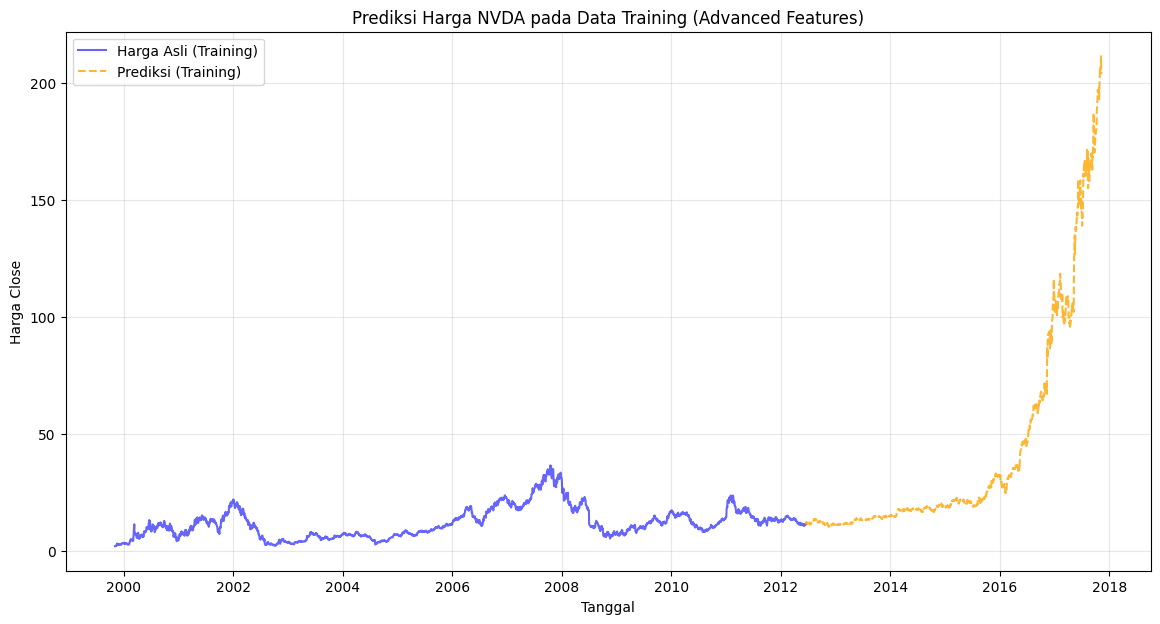

In [94]:
# --- VISUALISASI TRAINING DATA ---
plt.figure(figsize=(14, 7))

# Plot harga asli training
plt.plot(X_train.index, Y_train, label='Harga Asli (Training)', color='blue', alpha=0.6)

# Plot prediksi training
plt.plot(X_test.index, lr_pred, label='Prediksi (Training)', color='orange', linestyle='--', alpha=0.8)

plt.title('Prediksi Harga NVDA pada Data Training (Advanced Features)')
plt.xlabel('Tanggal')
plt.ylabel('Harga Close')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('visualisasi_training_data_advanced.png')

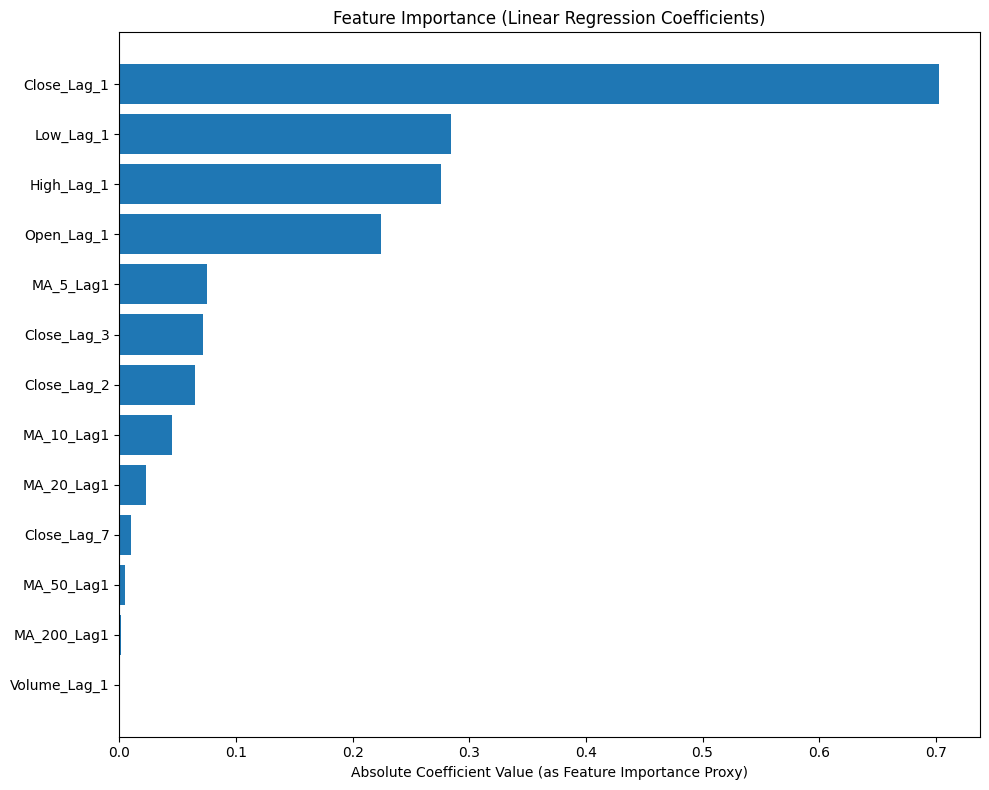

In [87]:
# Melihat Feature berpengaruh
importances = np.abs(lr_model.coef_)

feature_names = X_train.columns

indices = np.argsort(importances)

importances_sorted = importances[indices]
feature_names_sorted = feature_names[indices]

plt.figure(figsize=(10, 8))
plt.barh(range(X_train.shape[1]), importances_sorted, align="center")
plt.yticks(range(X_train.shape[1]), feature_names_sorted)
plt.xlabel("Absolute Coefficient Value (as Feature Importance Proxy)")
plt.title("Feature Importance (Linear Regression Coefficients)")
plt.tight_layout()
plt.savefig("feature_importances_lr.png")

# Predict the Market

In [95]:
def recursive_forecast_advanced(model, history_df, steps=5):
    predictions = []
    future_dates = []

    current_history = history_df.copy()
    last_date = current_history.index[-1]

    for i in range(steps):
        close_lag_1 = current_history['Close'].iloc[-1]
        close_lag_2 = current_history['Close'].iloc[-2]
        close_lag_3 = current_history['Close'].iloc[-3]
        close_lag_7 = current_history['Close'].iloc[-7]

        ma_5  = current_history['Close'].iloc[-5:].mean()
        ma_10 = current_history['Close'].iloc[-10:].mean()
        ma_20 = current_history['Close'].iloc[-20:].mean()
        ma_50 = current_history['Close'].iloc[-50:].mean()
        ma_200 = current_history['Close'].iloc[-200:].mean()

        open_lag_1 = current_history['Open'].iloc[-1]
        high_lag_1 = current_history['High'].iloc[-1]
        low_lag_1  = current_history['Low'].iloc[-1]
        volume_lag_1 = current_history['Volume'].iloc[-1]

        features = np.array([[
            close_lag_1, close_lag_3,
            ma_5, ma_10, ma_20,
            open_lag_1, high_lag_1, low_lag_1, volume_lag_1,
            close_lag_2, close_lag_7, ma_50, ma_200
        ]])

        pred_close = model.predict(features)[0]
        predictions.append(pred_close)

        next_date = last_date + pd.Timedelta(days=1)
        while next_date.weekday() >= 5:
            next_date += pd.Timedelta(days=1)
        last_date = next_date
        future_dates.append(next_date)

        volatility = current_history['Close'].diff().std()
        if np.isnan(volatility): volatility = 0

        sim_open = pred_close
        sim_high = pred_close + volatility
        sim_low  = pred_close - volatility
        sim_vol  = current_history['Volume'].iloc[-5:].mean()

        new_row = pd.DataFrame({
            'Open': [sim_open],
            'High': [sim_high],
            'Low': [sim_low],
            'Close': [pred_close],
            'Volume': [sim_vol]
        }, index=[next_date])

        current_history = pd.concat([current_history, new_row])

    return np.array(predictions), pd.Index(future_dates)


In [96]:
initial_history = df.iloc[-250:]

future_preds, future_dates = recursive_forecast_advanced(
    lr_model,           # Model Linear Regression yang sudah dilatih
    initial_history, # Data history terakhir
    steps=5        # Mau prediksi berapa hari ke depan?
)

for date, price in zip(future_dates, future_preds):
    print(f"{date.date()}: ${price:.2f}")

2017-11-13: $216.24
2017-11-14: $215.21
2017-11-15: $214.88
2017-11-16: $214.56
2017-11-17: $214.02


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


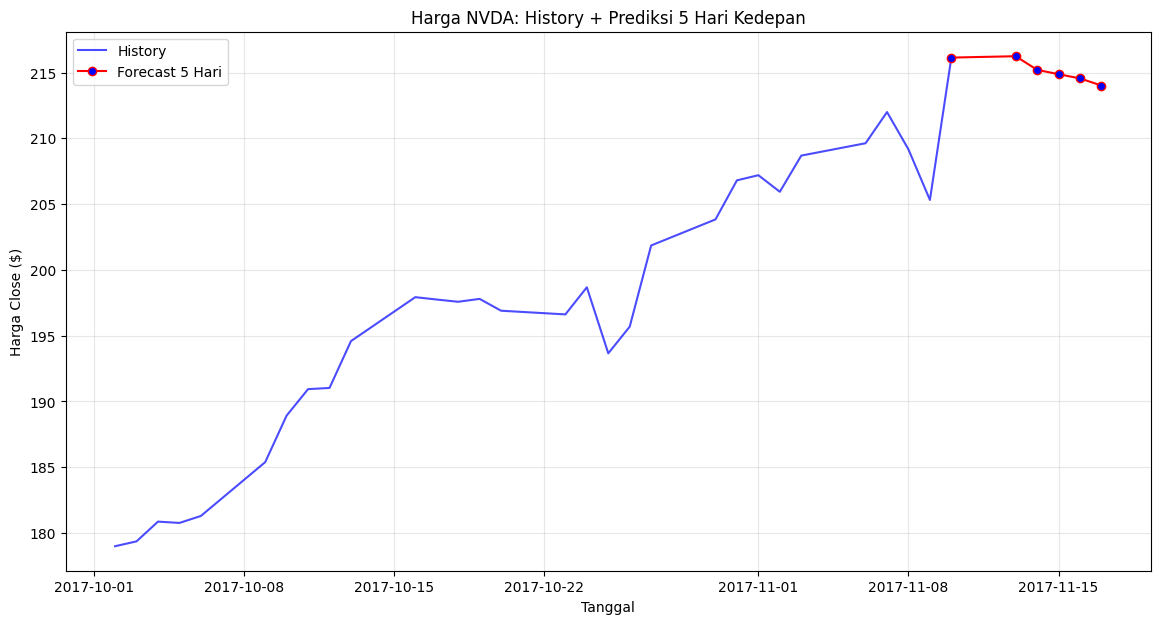

In [99]:
# Visualisasi nyambung dengan harga asli
start_date = '2017-10-01'
history_to_plot = df[df.index >= start_date]

plt.figure(figsize=(14, 7))
plt.plot(history_to_plot.index, history_to_plot['Close'], label='History', color='blue', alpha=0.7)

last_history_price = history_to_plot['Close'].iloc[-1]
pred_values_with_last = np.concatenate([[last_history_price], future_preds])
pred_dates_with_last = pd.Index([history_to_plot.index[-1]]).append(future_dates)

plt.plot(pred_dates_with_last, pred_values_with_last,
         label='Forecast 5 Hari',
         color='red',               # warna garis
         linestyle='-',
         marker='o',
         markerfacecolor='blue',    # isi lingkaran
         markeredgecolor='red')     # tepi lingkaran sama seperti garis

plt.title('Harga NVDA: History + Prediksi 5 Hari Kedepan')
plt.xlabel('Tanggal')
plt.ylabel('Harga Close ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
